<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Format" data-toc-modified-id="Format-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Format</a></span></li><li><span><a href="#Filtering" data-toc-modified-id="Filtering-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Filtering</a></span></li></ul></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plotting</a></span></li><li><span><a href="#Tree-subsample" data-toc-modified-id="Tree-subsample-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Tree subsample</a></span></li><li><span><a href="#RRPP" data-toc-modified-id="RRPP-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>RRPP</a></span><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#RRPP:-no-phy-cov" data-toc-modified-id="RRPP:-no-phy-cov-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>RRPP: no phy-cov</a></span><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

* RRPP analysis to assess correlations of OTUs and host phenotypes while controlling for host phylogeny
* Just assessing Methanobrevibacter ASVs versus body temperature

# Var

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/modulating/RRPP/'

# microbiome
## 16S-arch phyloseq object (one sample per individual)
physeq_arch_IndD_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/merged/phyloseq/physeq_arch_IndD_rare250.RDS'

# host tree
host_tree_IndD_file = '/ebio/abt3_projects/Georg_animal_feces/data/animal/phylogeny/TT/unified_metadata_complete_200429_16S-arch_IndD.nwk'

# body temp data
Tb_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/merged//bodyTemp_all.tsv'

# misc params
threads = 12
my_seed = 8394

# Init

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)

library(ape)
library(phyloseq)
library(RRPP)

library(doParallel)
library(LeyLabRMisc)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘RRPP’


The following object is masked from ‘package:phyloseq’:

    ordinate


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [3]:
# cluster job submission
#clustermq_setup()
#library(clustermq)

In [4]:
df.dims()
set.seed(my_seed)
make_dir(work_dir)
RhpcBLASctl::blas_set_num_threads(1)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/16S_arch/MiSeq-Runs-116-122-126-189-190/LLA/modulating/RRPP/ 


# Load

In [5]:
# phyloseq obj.
physeq = readRDS(physeq_arch_IndD_file) %>%
    subset_taxa(Genus == 'Methanothermobacter') %>%
    filter_taxa(function(x) sum(x > 0) >= 2, TRUE) %>%
    prune_samples(sample_sums(.) > 0, .) 
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14 taxa and 108 samples ]
sample_data() Sample Data:       [ 108 samples by 88 sample variables ]
tax_table()   Taxonomy Table:    [ 14 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 14 tips and 13 internal nodes ]

In [6]:
# otu table
otu = physeq %>%
    phyloseq2df(otu_table) %>%
    as.data.frame
rownames(otu) = otu$OTU
otu$OTU = NULL
otu = otu %>% t %>% as.data.frame
colnames(otu) = gsub('^([0-9])', 'X_\\1', colnames(otu))
otu

,X_9b65d80384f334ccb3620c5cd34343a5,f85dd79401796877f61d89e2bd643ee5,X_6752d08559e79e8b77d57291021aa328,X_7946378dfaa82c8687e96f8ab19a55a5,fc9e283f48f653c1b54f860d9cf996cf,X_859b0f9281126ff8d74d751373fd8891,X_44b7dc118025469372b59842c13d8642,b7ed842d3fbe5d8d33504a0a765409ae,X_17c38002e03cce9c9aabc6965e0c538c,cdb56ab386c439067f9b67e4a086370c,X_449fa8e4b7a2de0bb99e6a5e4cadb98b,f4c5b86cf1765317322d21fdb1dc2d4c,X_739635c4c0db52864efa6fc78c6a4d9e,X_39ea5d1cbc39f512ac935bd564de5b13
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F53_Mouflon,0,0,0,0,0.4,0.0,0,0,0,0,0,0,0,0
F66_Wild_Boar,0,0,0,0,0.0,1.2,0,0,0,0,2,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X94_Mangalica,0,0,0.0,0,0,2.8,0,2,0,0,0,0,0,0
X96_European_Hare,0,0,0.4,0,0,0.0,0,0,0,0,0,0,0,0


In [7]:
# host phylogeny
host_tree = read.tree(host_tree_IndD_file)
host_tree


Phylogenetic tree with 185 tips and 184 internal nodes.

Tip labels:
	X60_European_Chub, X179_Roach, X330_Ide, X327_Silver_Bream, X326_Silver_Bream, F14_Common_Bream, ...
Node labels:
	, @_20_@, @_17_@, @_14_@, @_9_@, @_15_@, ...

Rooted; includes branch lengths.

In [8]:
# metadata
metadata = physeq %>% 
    phyloseq2df(sample_data) %>%
    mutate(scientific_name = gsub(' ', '_', scientific_name),
           digestive_system = gsub('fermentation activity ', '', digestive_system),
           dig_sys = gsub('simple ', '', digestive_system)) %>%
    as.data.frame
rownames(metadata) = metadata$SampleID
metadata 

,SampleID,host_subject_id,host_german_name,host_common_name,scientific_name,scientific_name_subspecies,host_taxid,class,order,family,⋯,i.CH4_L.d_mean,i.CH4_L.d_sd,i.CH4_L.kgBM_mean,i.CH4_L.kgBM_sd,i.CH4_g.d_mean,i.CH4_g.d_sd,i.CH4_kJ.d_mean,i.CH4_kJ.d_sd,Sample,dig_sys
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
F53_Mouflon,F53_Mouflon,F53,Europaeischer Mufflon,Mouflon,Ovis_aries,Ovis aries musimon,9938,Mammalia,Artiodactyla,Bovidae,⋯,29.35006,9.543165,0.5260416,0.1785786,21.65932,7.180903,1161.102,377.627,F53_Mouflon,foregut
F66_Wild_Boar,F66_Wild_Boar,F66,Wildschwein,Wild.Boar,Sus_scrofa,NA,9823,Mammalia,Artiodactyla,Suidae,⋯,NA,NA,NA,NA,NA,NA,NA,NA,F66_Wild_Boar,simple
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X94_Mangalica,X94_Mangalica,94,Mangalicaschwein,Mangalica,Sus_scrofa,Sus scrofa domesticus,9825,Mammalia,Artiodactyla,Suidae,⋯,NA,NA,NA,NA,NA,NA,NA,NA,X94_Mangalica,simple
X96_European_Hare,X96_European_Hare,96,Feldhase,European.Hare,Lepus_europaeus,NA,9983,Mammalia,Lagomorpha,Leporidae,⋯,NA,NA,NA,NA,NA,NA,NA,NA,X96_European_Hare,hindgut


In [9]:
# body temp
metadata = metadata %>%
    inner_join(read.delim(Tb_file) %>% 
                   dplyr::select(scientific_name, dataset, Tb) %>%
                   mutate(scientific_name = gsub(' ', '_', scientific_name)),
               c('scientific_name')) %>%
    rename('dataset_Tb' = dataset)

metadata %>% .$Tb %>% summary_x
metadata 

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,NA's,sd,sd_err_of_mean
.,30.7,37.55,39,38.65769,40.2,41.9,30,4.652,1.758


SampleID,host_subject_id,host_german_name,host_common_name,scientific_name,scientific_name_subspecies,host_taxid,class,order,family,⋯,i.CH4_L.kgBM_mean,i.CH4_L.kgBM_sd,i.CH4_g.d_mean,i.CH4_g.d_sd,i.CH4_kJ.d_mean,i.CH4_kJ.d_sd,Sample,dig_sys,dataset_Tb,Tb
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
F53_Mouflon,F53,Europaeischer Mufflon,Mouflon,Ovis_aries,Ovis aries musimon,9938,Mammalia,Artiodactyla,Bovidae,⋯,0.5260416,0.1785786,21.65932,7.180903,1161.102,377.627,F53_Mouflon,foregut,WalzerXXXX,39.2
F66_Wild_Boar,F66,Wildschwein,Wild.Boar,Sus_scrofa,NA,9823,Mammalia,Artiodactyla,Suidae,⋯,NA,NA,NA,NA,NA,NA,F66_Wild_Boar,simple,WalzerXXXX,36.6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X94_Mangalica,94,Mangalicaschwein,Mangalica,Sus_scrofa,Sus scrofa domesticus,9825,Mammalia,Artiodactyla,Suidae,⋯,NA,NA,NA,NA,NA,NA,X94_Mangalica,simple,WalzerXXXX,36.6
X96_European_Hare,96,Feldhase,European.Hare,Lepus_europaeus,NA,9983,Mammalia,Lagomorpha,Leporidae,⋯,NA,NA,NA,NA,NA,NA,X96_European_Hare,hindgut,NA,NA


## Format

In [10]:
vars = c('Tb')
otu = cbind(metadata[,vars, drop=FALSE], otu)
otu

,Tb,X_9b65d80384f334ccb3620c5cd34343a5,f85dd79401796877f61d89e2bd643ee5,X_6752d08559e79e8b77d57291021aa328,X_7946378dfaa82c8687e96f8ab19a55a5,fc9e283f48f653c1b54f860d9cf996cf,X_859b0f9281126ff8d74d751373fd8891,X_44b7dc118025469372b59842c13d8642,b7ed842d3fbe5d8d33504a0a765409ae,X_17c38002e03cce9c9aabc6965e0c538c,cdb56ab386c439067f9b67e4a086370c,X_449fa8e4b7a2de0bb99e6a5e4cadb98b,f4c5b86cf1765317322d21fdb1dc2d4c,X_739635c4c0db52864efa6fc78c6a4d9e,X_39ea5d1cbc39f512ac935bd564de5b13
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F53_Mouflon,39.2,0,0,0,0,0.4,0.0,0,0,0,0,0,0,0,0
F66_Wild_Boar,36.6,0,0,0,0,0.0,1.2,0,0,0,0,2,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X94_Mangalica,36.6,0,0,0.0,0,0,2.8,0,2,0,0,0,0,0,0
X96_European_Hare,NA,0,0,0.4,0,0,0.0,0,0,0,0,0,0,0,0


## Filtering

In [11]:
# filtering otu
otu = otu[!is.na(otu$Tb),]
otu

,Tb,X_9b65d80384f334ccb3620c5cd34343a5,f85dd79401796877f61d89e2bd643ee5,X_6752d08559e79e8b77d57291021aa328,X_7946378dfaa82c8687e96f8ab19a55a5,fc9e283f48f653c1b54f860d9cf996cf,X_859b0f9281126ff8d74d751373fd8891,X_44b7dc118025469372b59842c13d8642,b7ed842d3fbe5d8d33504a0a765409ae,X_17c38002e03cce9c9aabc6965e0c538c,cdb56ab386c439067f9b67e4a086370c,X_449fa8e4b7a2de0bb99e6a5e4cadb98b,f4c5b86cf1765317322d21fdb1dc2d4c,X_739635c4c0db52864efa6fc78c6a4d9e,X_39ea5d1cbc39f512ac935bd564de5b13
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F53_Mouflon,39.2,0,0,0,0,0.4,0.0,0,0,0,0,0,0,0,0
F66_Wild_Boar,36.6,0,0,0,0,0.0,1.2,0,0,0,0,2,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X93_Red_Sheep,39.2,0.4,0.8,0.4,0,0,1.2,0,2,2,0.4,0,0,0.4,0.4
X94_Mangalica,36.6,0.0,0.0,0.0,0,0,2.8,0,2,0,0.0,0,0,0.0,0.0


In [12]:
# sparsity
prev = apply(otu[,2:ncol(otu)], 2, function(x) sum(x > 0) / length(x) * 100)
to_keep = c('Tb', names(prev[prev >= 5]))
otu = otu[,to_keep]
otu

,Tb,X_9b65d80384f334ccb3620c5cd34343a5,f85dd79401796877f61d89e2bd643ee5,X_6752d08559e79e8b77d57291021aa328,X_859b0f9281126ff8d74d751373fd8891,X_44b7dc118025469372b59842c13d8642,b7ed842d3fbe5d8d33504a0a765409ae,X_17c38002e03cce9c9aabc6965e0c538c,cdb56ab386c439067f9b67e4a086370c,X_449fa8e4b7a2de0bb99e6a5e4cadb98b,f4c5b86cf1765317322d21fdb1dc2d4c,X_739635c4c0db52864efa6fc78c6a4d9e,X_39ea5d1cbc39f512ac935bd564de5b13
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F53_Mouflon,39.2,0,0,0,0.0,0,0,0,0,0,0,0,0
F66_Wild_Boar,36.6,0,0,0,1.2,0,0,0,0,2,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X93_Red_Sheep,39.2,0.4,0.8,0.4,1.2,0,2,2,0.4,0,0,0.4,0.4
X94_Mangalica,36.6,0.0,0.0,0.0,2.8,0,2,0,0.0,0,0,0.0,0.0


In [13]:
# filtering tree
to_rm = setdiff(host_tree$tip.label, rownames(otu))
host_tree = ape::drop.tip(host_tree, to_rm)
host_tree


Phylogenetic tree with 78 tips and 77 internal nodes.

Tip labels:
	X372_Emu, X33_Wild_Turkey, X31_Chicken, X271_Common_Pheasant, X270_Common_Pheasant, X259_Mute_Swan, ...
Node labels:
	@_196_@, @_89_@, @_88_@, @_46_@, @_40_@, @_39_@, ...

Rooted; includes branch lengths.

In [14]:
# checking overlap
overlap(host_tree$tip.label, rownames(otu))

intersect(x,y): 78 
setdiff(x,y): 0 
setdiff(y,x): 0 
union(x,y): 78 


# Plotting

In [15]:
tax = physeq %>%
    phyloseq2df(tax_table) %>%
    mutate(OTU = gsub('^([0-9])', 'X_\\1', OTU))
tax

Domain,Phylum,Class,Order,Family,Genus,Species,OTU
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,Methanothermobacter marburgensis str. Marburg,X_9b65d80384f334ccb3620c5cd34343a5
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,Methanothermobacter marburgensis str. Marburg,f85dd79401796877f61d89e2bd643ee5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,unclassified,X_739635c4c0db52864efa6fc78c6a4d9e
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,unclassified,X_39ea5d1cbc39f512ac935bd564de5b13


In [16]:
# joining
otu_j = otu %>%
    mutate(Sample = rownames(.)) %>%
    gather(OTU, perc_abund, -Tb, -Sample) %>%
    dplyr::select(-Tb) %>%
    inner_join(metadata, c('Sample'='SampleID')) %>%
    filter(!is.na(Tb)) %>%
    inner_join(tax, c('OTU')) 
otu_j

Sample,OTU,perc_abund,host_subject_id,host_german_name,host_common_name,scientific_name,scientific_name_subspecies,host_taxid,class,⋯,dig_sys,dataset_Tb,Tb,Domain,Phylum,Class,Order,Family,Genus,Species
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,⋯,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
F53_Mouflon,X_9b65d80384f334ccb3620c5cd34343a5,0,F53,Europaeischer Mufflon,Mouflon,Ovis_aries,Ovis aries musimon,9938,Mammalia,⋯,foregut,WalzerXXXX,39.2,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,Methanothermobacter marburgensis str. Marburg
F66_Wild_Boar,X_9b65d80384f334ccb3620c5cd34343a5,0,F66,Wildschwein,Wild.Boar,Sus_scrofa,NA,9823,Mammalia,⋯,simple,WalzerXXXX,36.6,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,Methanothermobacter marburgensis str. Marburg
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
X93_Red_Sheep,X_39ea5d1cbc39f512ac935bd564de5b13,0.4,93,Hausschaf,Red.Sheep,Ovis_aries,NA,9940,Mammalia,⋯,foregut,WalzerXXXX,39.2,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,unclassified
X94_Mangalica,X_39ea5d1cbc39f512ac935bd564de5b13,0.0,94,Mangalicaschwein,Mangalica,Sus_scrofa,Sus scrofa domesticus,9825,Mammalia,⋯,simple,WalzerXXXX,36.6,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,unclassified


`geom_smooth()` using formula 'y ~ x'



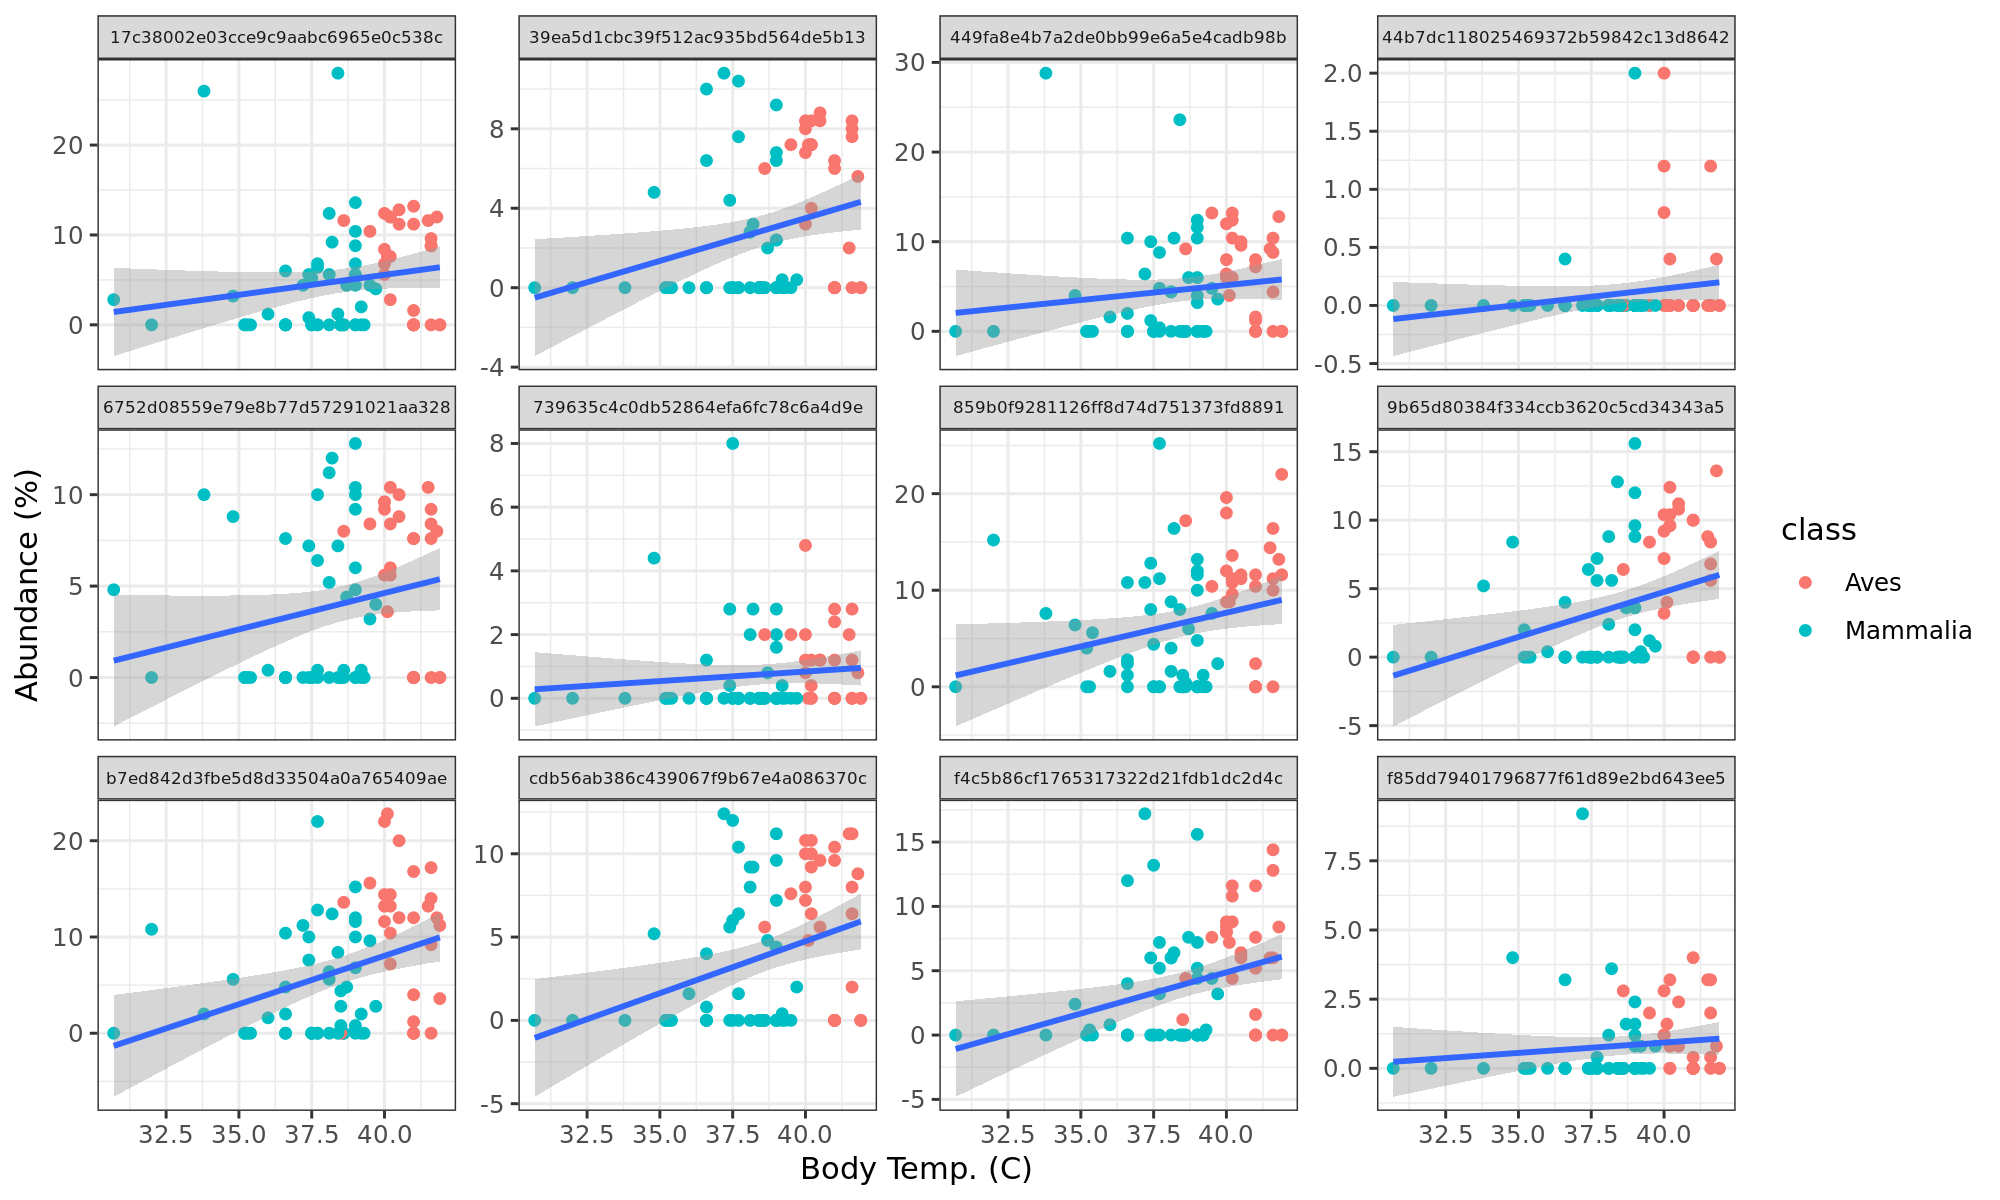

In [17]:
# plotting
p = otu_j %>%
    mutate(OTU = gsub('X_', '', OTU)) %>%
    ggplot(aes(Tb, perc_abund)) +
    geom_point(aes(color=class)) +
    geom_smooth(method='lm') +
    labs(x='Body Temp. (C)', y='Abundance (%)') +
    facet_wrap(~ OTU, scales='free_y') +
    theme_bw() +
    theme(
        strip.text = element_text(size=6)
    )

p.dims(10,6)
plot(p)

# Tree subsample

In [18]:
#' randomly selecting one per group
tree_subsample = function(L, df, tree){
    # get subsample (note: subsampling within each species)
    to_keep = df %>% 
        group_by(scientific_name) %>% 
        sample_n(1) %>%
        .$sample
    # subsampling tree
    to_rm = setdiff(tree$tip.label, to_keep)
    tree = drop.tip(tree, to_rm)
    return(tree)
}

In [19]:
# replicate analyses with different subsets of the host phylogeny
n_reps = 100

In [20]:
# permuted trees
df = metadata %>%
    mutate(sample = SampleID) %>%
    dplyr::select(sample, scientific_name) 

doParallel::registerDoParallel(threads)
host_tree_l = plyr::llply(as.list(1:n_reps), 
                          function(x) tree_subsample(x, df, host_tree),
                          .parallel=TRUE)
host_tree_l %>% length

[1] 100

In [31]:
# samples per permuted tree
host_tree_l %>% lapply(function(x) length(x$tip.label)) %>% as.numeric %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     52      52      52      52      52      52 

# RRPP

In [21]:
.rrpp_per = function(tree, taxon, otu, iter=999){
    # tree
    PhyCov = ape::vcv(tree, model = "Brownian")
    # otu
    otu_f = otu[rownames(PhyCov),]
    data = list(OTUs = otu_f[,taxon] %>% as.matrix,
                Tb = otu_f$Tb)
    names(data[['Tb']]) = rownames(otu_f)
    # rrpp
    fitGLS = lm.rrpp(OTUs ~ Tb, data = data, Cov = PhyCov,
                     print.progress = FALSE, SS.type = "II", iter = iter)
    anova(fitGLS)$table
}

rrpp_per = function(taxon, otu, trees, iter=999){
    df = trees %>% 
        plyr::llply(.rrpp_per, taxon=taxon, otu=otu, iter=iter, .parallel=FALSE) %>%
        do.call(rbind, .) %>%
        mutate(feature = gsub('[0-9]+$', '', rownames(.))) 
    df$taxon = taxon
    return(df)   
}

In [22]:
#running for all OTUs & all trees
taxa = colnames(otu)[2:ncol(otu)]
taxa %>% length %>% cat('Number of OTUs:', ., '\n')

doParallel::registerDoParallel(threads)
rrpp_res = taxa %>%
    plyr::llply(rrpp_per, otu, host_tree_l, iter=999, .parallel=TRUE) %>%
    do.call(rbind, .) %>%
    filter(feature == 'Tb')
rrpp_res

Number of OTUs: 12 


Df,SS,MS,Rsq,F,Z,Pr(>F),feature,taxon
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,0.01683852,0.01683852,0.0008348461,0.04177718,-0.7618994,0.812,Tb,X_9b65d80384f334ccb3620c5cd34343a5
1,0.06888871,0.06888871,0.0036851684,0.18493995,-0.1463434,0.646,Tb,X_9b65d80384f334ccb3620c5cd34343a5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,0.202468573,0.202468573,0.0235225589,1.20445993,0.6339010,0.267,Tb,X_39ea5d1cbc39f512ac935bd564de5b13
1,0.006150762,0.006150762,0.0006290816,0.03147388,-0.8915904,0.848,Tb,X_39ea5d1cbc39f512ac935bd564de5b13


## Summary

In [23]:
# formatting
rrpp_res_s = rrpp_res %>%
    rename('P' = `Pr(>F)`) %>%
    group_by(taxon) %>%
    mutate(P = (length(P) - sum(P < 0.05)) / length(P)) %>%
    ungroup() %>%
    mutate(Q = p.adjust(P, method='BH'))

rrpp_res_s %>% .$P %>% summary_x('P')
rrpp_res_s %>% .$Q %>% summary_x('Adj. P')
rrpp_res_s

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
P,0.91,1,1,0.9925,1,1,0.036,0.015


,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
Adj. P,1,1,1,1,1,1,0,0


Df,SS,MS,Rsq,F,Z,P,feature,taxon,Q
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,0.01683852,0.01683852,0.0008348461,0.04177718,-0.7618994,1,Tb,X_9b65d80384f334ccb3620c5cd34343a5,1
1,0.06888871,0.06888871,0.0036851684,0.18493995,-0.1463434,1,Tb,X_9b65d80384f334ccb3620c5cd34343a5,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,0.202468573,0.202468573,0.0235225589,1.20445993,0.6339010,1,Tb,X_39ea5d1cbc39f512ac935bd564de5b13,1
1,0.006150762,0.006150762,0.0006290816,0.03147388,-0.8915904,1,Tb,X_39ea5d1cbc39f512ac935bd564de5b13,1


In [24]:
# significant taxa
tax = physeq %>%
    phyloseq2df(tax_table) %>%
    mutate(OTU = gsub('^([0-9])', 'X_\\1', OTU))

rrpp_res_s_f = rrpp_res_s %>%
    filter(Q < 0.05) %>%
    inner_join(tax, c('taxon'='OTU'))
rrpp_res_s_f

Df,SS,MS,Rsq,F,Z,P,feature,taxon,Q,Domain,Phylum,Class,Order,Family,Genus,Species
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>


# RRPP: no phy-cov

In [25]:
.rrpp_per = function(tree, taxon, otu, iter=999){
    # tree
    PhyCov = ape::vcv(tree, model = "Brownian")
    # otu
    otu_f = otu[rownames(PhyCov),]
    data = list(OTUs = otu_f[,taxon] %>% as.matrix,
                Tb = otu_f$Tb)
    names(data[['Tb']]) = rownames(otu_f)
    # rrpp
    fitGLS = lm.rrpp(OTUs ~ Tb, data = data,
                     print.progress = FALSE, SS.type = "II", iter = iter)
    anova(fitGLS)$table
}

rrpp_per = function(taxon, otu, trees, iter=999){
    df = trees %>% 
        plyr::llply(.rrpp_per, taxon=taxon, otu=otu, iter=iter, .parallel=FALSE) %>%
        do.call(rbind, .) %>%
        mutate(feature = gsub('[0-9]+$', '', rownames(.))) 
    df$taxon = taxon
    return(df)   
}

In [26]:
#running for all OTUs & all trees
taxa = colnames(otu)[2:ncol(otu)]
taxa %>% length %>% cat('Number of OTUs:', ., '\n')

doParallel::registerDoParallel(threads)
rrpp_res = taxa %>%
    plyr::llply(rrpp_per, otu, host_tree_l, iter=999, .parallel=TRUE) %>%
    do.call(rbind, .) %>%
    filter(feature == 'Tb')
rrpp_res

Number of OTUs: 12 


Df,SS,MS,Rsq,F,Z,Pr(>F),feature,taxon
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,133.8892,133.8892,0.1250708,7.147481,1.397203,0.009,Tb,X_9b65d80384f334ccb3620c5cd34343a5
1,139.4581,139.4581,0.1406548,8.183834,1.463653,0.006,Tb,X_9b65d80384f334ccb3620c5cd34343a5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,85.18325,85.18325,0.1251364,7.151767,1.426662,0.007,Tb,X_39ea5d1cbc39f512ac935bd564de5b13
1,83.59404,83.59404,0.1201978,6.830954,1.434221,0.010,Tb,X_39ea5d1cbc39f512ac935bd564de5b13


## Summary

In [27]:
# formatting
rrpp_res_s = rrpp_res %>%
    rename('P' = `Pr(>F)`) %>%
    group_by(taxon) %>%
    mutate(P = (length(P) - sum(P < 0.05)) / length(P)) %>%
    ungroup() %>%
    mutate(Q = p.adjust(P, method='BH'))

rrpp_res_s %>% .$P %>% summary_x('P')
rrpp_res_s %>% .$Q %>% summary_x('Adj. P')
rrpp_res_s

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
P,0,0,0.865,0.5608333,1,1,0.47,0.192


,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
Adj. P,0,0,1,0.5833333,1,1,0.49,0.2


Df,SS,MS,Rsq,F,Z,P,feature,taxon,Q
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,133.8892,133.8892,0.1250708,7.147481,1.397203,0,Tb,X_9b65d80384f334ccb3620c5cd34343a5,0
1,139.4581,139.4581,0.1406548,8.183834,1.463653,0,Tb,X_9b65d80384f334ccb3620c5cd34343a5,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,85.18325,85.18325,0.1251364,7.151767,1.426662,0,Tb,X_39ea5d1cbc39f512ac935bd564de5b13,0
1,83.59404,83.59404,0.1201978,6.830954,1.434221,0,Tb,X_39ea5d1cbc39f512ac935bd564de5b13,0


In [28]:
# significant taxa
tax = physeq %>%
    phyloseq2df(tax_table) %>%
    mutate(OTU = gsub('^([0-9])', 'X_\\1', OTU))

rrpp_res_s_f = rrpp_res_s %>%
    filter(Q < 0.05) %>%
    inner_join(tax, c('taxon'='OTU'))
rrpp_res_s_f

Df,SS,MS,Rsq,F,Z,P,feature,taxon,Q,Domain,Phylum,Class,Order,Family,Genus,Species
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,133.8892,133.8892,0.1250708,7.147481,1.397203,0,Tb,X_9b65d80384f334ccb3620c5cd34343a5,0,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,Methanothermobacter marburgensis str. Marburg
1,139.4581,139.4581,0.1406548,8.183834,1.463653,0,Tb,X_9b65d80384f334ccb3620c5cd34343a5,0,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,Methanothermobacter marburgensis str. Marburg
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,85.18325,85.18325,0.1251364,7.151767,1.426662,0,Tb,X_39ea5d1cbc39f512ac935bd564de5b13,0,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,unclassified
1,83.59404,83.59404,0.1201978,6.830954,1.434221,0,Tb,X_39ea5d1cbc39f512ac935bd564de5b13,0,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteraceae,Methanothermobacter,unclassified


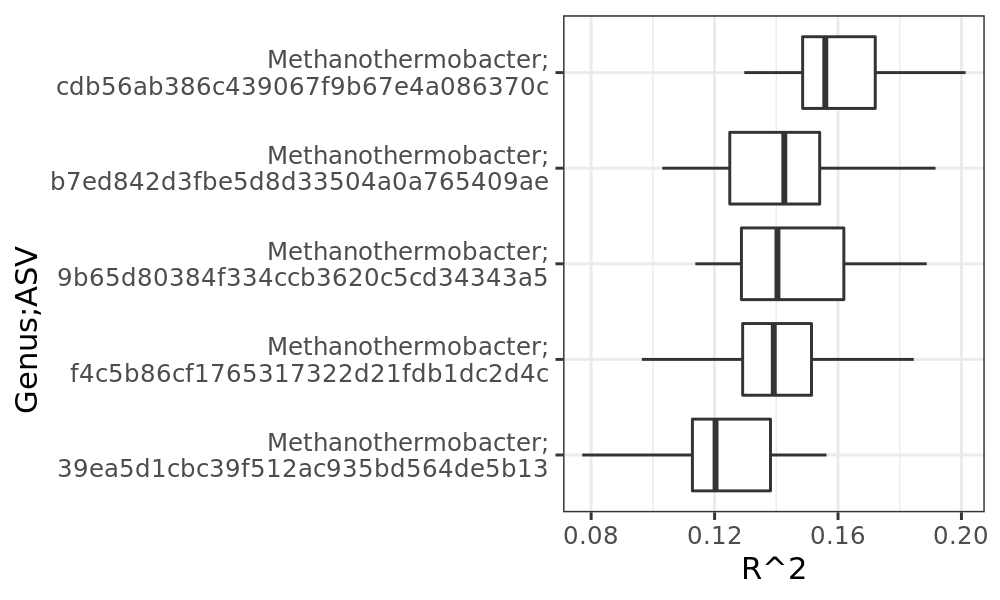

In [29]:
# plotting
p = rrpp_res_s_f %>%
    mutate(taxon = gsub('^X_', '', taxon)) %>%
    mutate(Taxonomy = paste(Genus, taxon, sep='; '),
           Genus = gsub(' ', '\n', Genus),
           Taxonomy = stringr::str_wrap(Taxonomy, 20)) %>%
    group_by(Taxonomy) %>%
    mutate(mean_Rsq = median(Rsq)) %>%
    ungroup() %>%
    mutate(Taxonomy = Taxonomy %>% reorder(mean_Rsq)) %>%
    ggplot(aes(Taxonomy, Rsq)) +
    geom_boxplot() +
    labs(x='Genus;ASV', y='R^2') +
    theme_bw() +
    theme(
        axis.title.y = element_text(hjust = 0.3)
    ) +
    coord_flip()

p.dims(5,3)
plot(p)

# sessionInfo

In [30]:
sessionInfo()

R version 4.0.0 (2020-04-24)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Georg_animal_feces/envs/phyloseq-physig/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] LeyLabRMisc_0.1.6 doParallel_1.0.15 iterators_1.0.12  foreach_1.5.0    
 [5] RRPP_0.6.0        phyloseq_1.32.0   ape_5.4           ggplot2_3.3.1    
 [9] tidyr_1.1.0       dplyr_1.0.0      

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.4.6      